**Predicting a Tennis Player's Rank**

Section 004

Jonathan Chan (34466219), Erick Jovan Muljadi (96641055), Katie Swangard (13265202), Aurora Wang (47454038)

In [1]:
# Loading in necessary libraries and setting the seed:
set.seed(0004)
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(digest)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Background Information**

ATP is a worldwide top-tier tennis tour for men organized by the Association of Tennis Professionals.  The question we are trying to ask is: based on three given characteristics of a new player (height, age and hand use), what ATP ranking will he achieve on each of the three different surfaces?  

We will use the dataset "Match Results for Top 500 Players 2017-2019". This data set includes the game statistics from 2017-2019 tournaments. It contains the ranking, results and match statistics of the top 500 players in the ATP, as well as individual characteristics of the winners and losers of each match, such as height, age, and hand use. 



In [2]:
# Reading in our dataset:
print("Table 1: The dataset used in this data analysis.")
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")|>
    rename("ID_num" = 1)
# As the whole dataset would be too large to display, we are only displaying the first 10 rows here.
head(tennis)

[1] "Table 1: The dataset used in this data analysis."


New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID_num,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


In [3]:
# Selecting only for rows needed in our data analysis:
tennis_smaller <- tennis|>
    select(ID_num,winner_ht,winner_age, winner_rank,surface,loser_ht, loser_age, loser_rank)|>
    mutate(ID_num = as_factor(ID_num)) # Mutating ID_num and winner_hand into factor columns.
# Combining winner and loser data into one column:
tennis_pivot <- tennis_smaller |>
    pivot_longer(cols = c("winner_rank", "loser_rank"),
                     names_to = "wol_rank",
                     values_to = "rank") |>
    pivot_longer(cols = c("winner_ht", "loser_ht"),
                     names_to = "wol_height",
                     values_to = "height") |>
    pivot_longer(cols = c("winner_age", "loser_age"),
                     names_to = "wol_age",)

# Filtering all NA data in surface
tennis_filtered <- tennis_pivot |>
                    drop_na() |>
                    filter(surface != "None")
print("Table 2: The first 10 columns of the dataset after the data has been tidied and wrangled.")
head(tennis_filtered, 10) # Displaying the top 10 columns.

[1] "Table 2: The first 10 columns of the dataset after the data has been tidied and wrangled."


ID_num,surface,wol_rank,rank,wol_height,height,wol_age,value
<fct>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
0,Hard,winner_rank,9,winner_ht,178,winner_age,29.00479
0,Hard,winner_rank,9,winner_ht,178,loser_age,22.88569
0,Hard,loser_rank,16,winner_ht,178,winner_age,29.00479
0,Hard,loser_rank,16,winner_ht,178,loser_age,22.88569
1,Hard,winner_rank,16,loser_ht,188,winner_age,22.88569
1,Hard,winner_rank,16,loser_ht,188,loser_age,33.70568
1,Hard,loser_rank,239,loser_ht,188,winner_age,22.88569
1,Hard,loser_rank,239,loser_ht,188,loser_age,33.70568
2,Hard,winner_rank,9,winner_ht,178,winner_age,29.00479


We cleaned and wrangled the data by selecting only the columns we required for our data analysis and by combining the columns for winner rank and loser rank.  We did the same for the columns that contained information on the winner and loser's age and height.  


In [4]:
# Groupping by rank, surface, and hand, then finding mean height and age.
tennis_mean <- tennis_filtered|>
    group_by(rank,surface) |>
    summarize(mean_ht = mean(height, na.rm = TRUE), mean_age = mean(value))
# Displaying only the top 10 columns due to space constraints:
print("Table 3: The dataset after groupping by rank, surface, and hand of player, and with mean height and age.")
head(tennis_mean, 10)

`summarise()` has grouped output by 'rank'. You can override using the
`.groups` argument.


[1] "Table 3: The dataset after groupping by rank, surface, and hand of player, and with mean height and age."


rank,surface,mean_ht,mean_age
<dbl>,<chr>,<dbl>,<dbl>
1,Clay,186.4505,29.59975
1,Grass,186.2683,30.87157
1,Hard,187.1657,29.80148
2,Clay,185.1184,29.92952
2,Grass,186.2647,32.04429
2,Hard,186.0261,31.04105
3,Clay,191.1176,27.40492
3,Grass,186.1481,31.26296
3,Hard,188.9744,29.70861


In [5]:
# Splitting our data 75/25 into training and testing data:
tennis_split <- initial_split(tennis_mean, prop = 0.75, strata = rank )
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

In [6]:
print("Table 4: The training data used in this data analysis, consisting of 25% of the original dataset.")
head(tennis_training)

[1] "Table 4: The training data used in this data analysis, consisting of 25% of the original dataset."


rank,surface,mean_ht,mean_age
<dbl>,<chr>,<dbl>,<dbl>
1,Clay,186.4505,29.59975
1,Grass,186.2683,30.87157
1,Hard,187.1657,29.80148
2,Clay,185.1184,29.92952
2,Grass,186.2647,32.04429
3,Clay,191.1176,27.40492


We split the data into training and testing sets (using a 75/25 split).

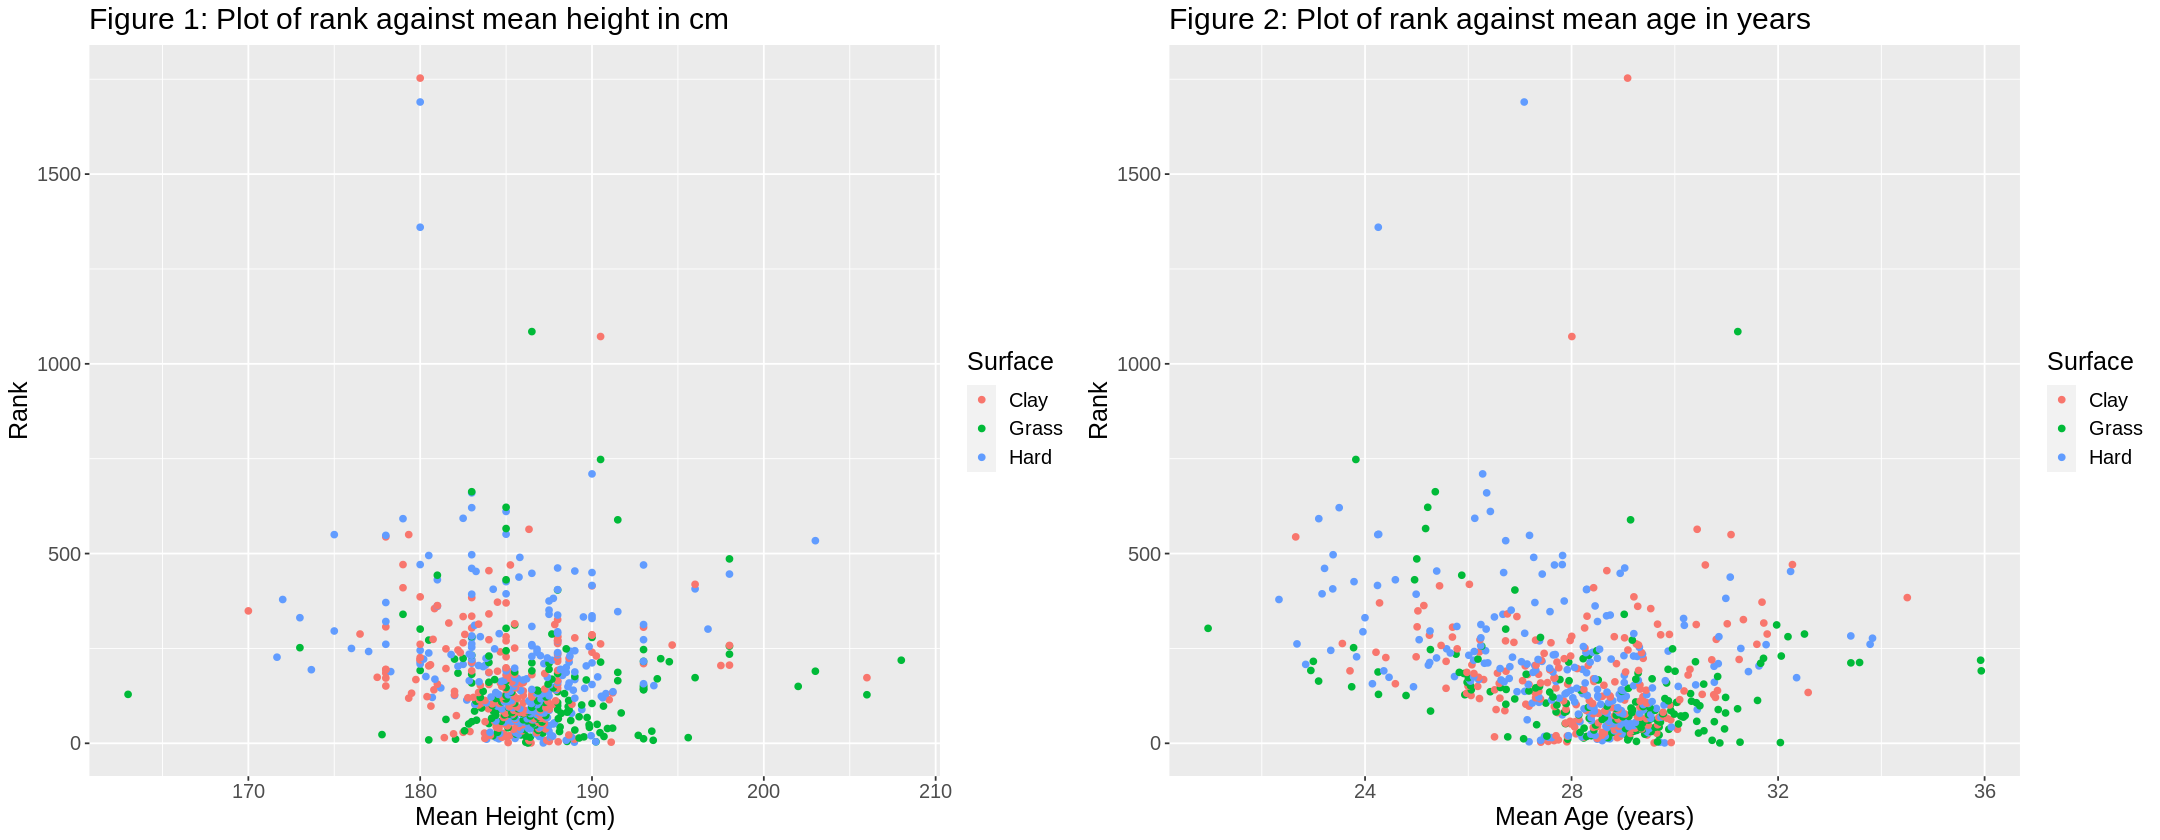

In [7]:
# Plotting rank against mean age:
options(repr.plot.width = 18, repr.plot.height = 7)
rank_vs_age_plot <- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_age, y=rank, color = surface))+
    geom_point() +
    labs(x = "Mean Age (years)", y = "Rank", color = "Surface") +
    ggtitle("Figure 2: Plot of rank against mean age in years")+
    theme(text=element_text(size = 15))

# Plotting height against mean age:
rank_vs_height_plot<- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_ht, y=rank, color = surface))+
    geom_point() +
    labs(x = "Mean Height (cm)", y = "Rank", colour = "Surface") +
    ggtitle("Figure 1: Plot of rank against mean height in cm")+
    theme(text=element_text(size = 15))
# use plot grid
tennis_plots <- plot_grid(rank_vs_height_plot, rank_vs_age_plot)
tennis_plots

We then used two plots to visualise the relationship between height and rank and the relationship between age and rank.  We coloured the data points by the surface of the court so that we could see if the type of court played a role.  

In [8]:
# Creating a workflow for further data analysis and prediction using regression:
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                  set_engine("kknn") |>
                  set_mode("regression") 

tennis_recipe <- recipe(rank ~ mean_ht + mean_age, data = tennis_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

tennis_workflow <- workflow() |>
                    add_recipe(tennis_recipe) |>
                    add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [9]:
set.seed(0004)
gridvals <- tibble(neighbors = 1:200)
tennis_vfold <- vfold_cv(tennis_training, v=10, strata = rank)
tennis_k_value <- tennis_workflow|>
    tune_grid(resamples = tennis_vfold, grid = gridvals)|>
    collect_metrics()|>
    filter(.metric == "rmse")|>
    filter(mean == min(mean))|>
    pull(neighbors)
    
tennis_k_value

[1] 63

We used cross-validation with 10 folds and 200 values of K to find the best value of K.  We found that the optimal value of K.

In [10]:
tennis_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = tennis_k_value) |> 
                  set_engine("kknn") |>
                  set_mode("regression") 
tennis_fit <- workflow()|>
    add_recipe(tennis_recipe)|>
    add_model(tennis_spec_best)|>
    fit(data = tennis_training)
tennis_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(63L,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 91.32714
Minimal mean squared error: 24767.09
Best kernel: rectangular
Best k: 63

We created a new model and workflow using our optimal value of K and fit this to our training data.  

In [15]:
tennis_accuracy <- tennis_fit |>
    predict(tennis_testing)|>
    bind_cols(tennis_testing)
print("Table 4: The first 6 rows of our predictive model's predictions on the testing data, showing predicted and actual rank.")
head(tennis_accuracy)

tennis_summary <- tennis_accuracy |>
    metrics(truth = rank, estimate = .pred)|>
    filter(.metric == "rmse")
print("Table 5: The RMSPE value of our predictive model.")
tennis_summary

[1] "Table 4: The first 6 rows of our predictive model's predictions on the testing data, showing predicted and actual rank."


.pred,rank,surface,mean_ht,mean_age
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
159.3175,2,Hard,186.0261,31.04105
188.8571,5,Hard,189.5650,27.14104
155.4444,6,Clay,188.7778,28.08085
158.7302,6,Grass,193.2500,29.43559
159.9683,6,Hard,190.6296,28.67262
131.8571,7,Grass,189.7188,29.25411


[1] "Table 5: The RMSPE value of our predictive model."


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,180.5741


We used our new model to predict the rank of our testing data and also computed its RMSPE which was: 180.57

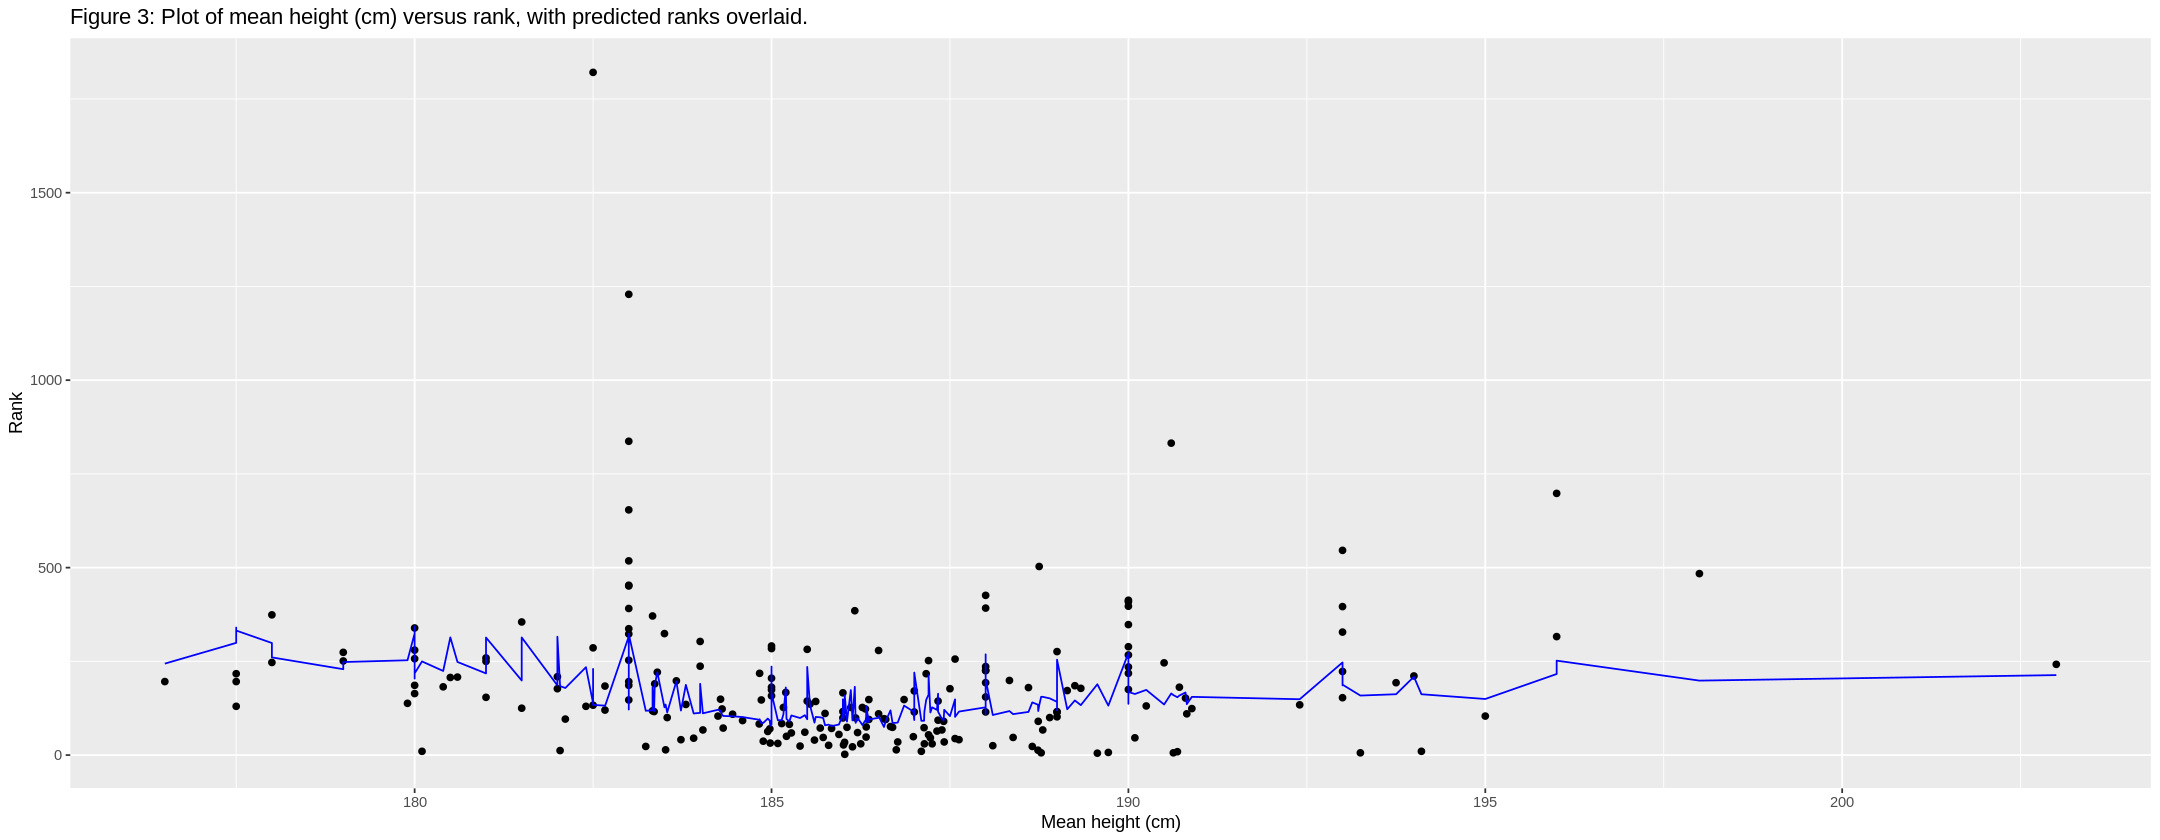

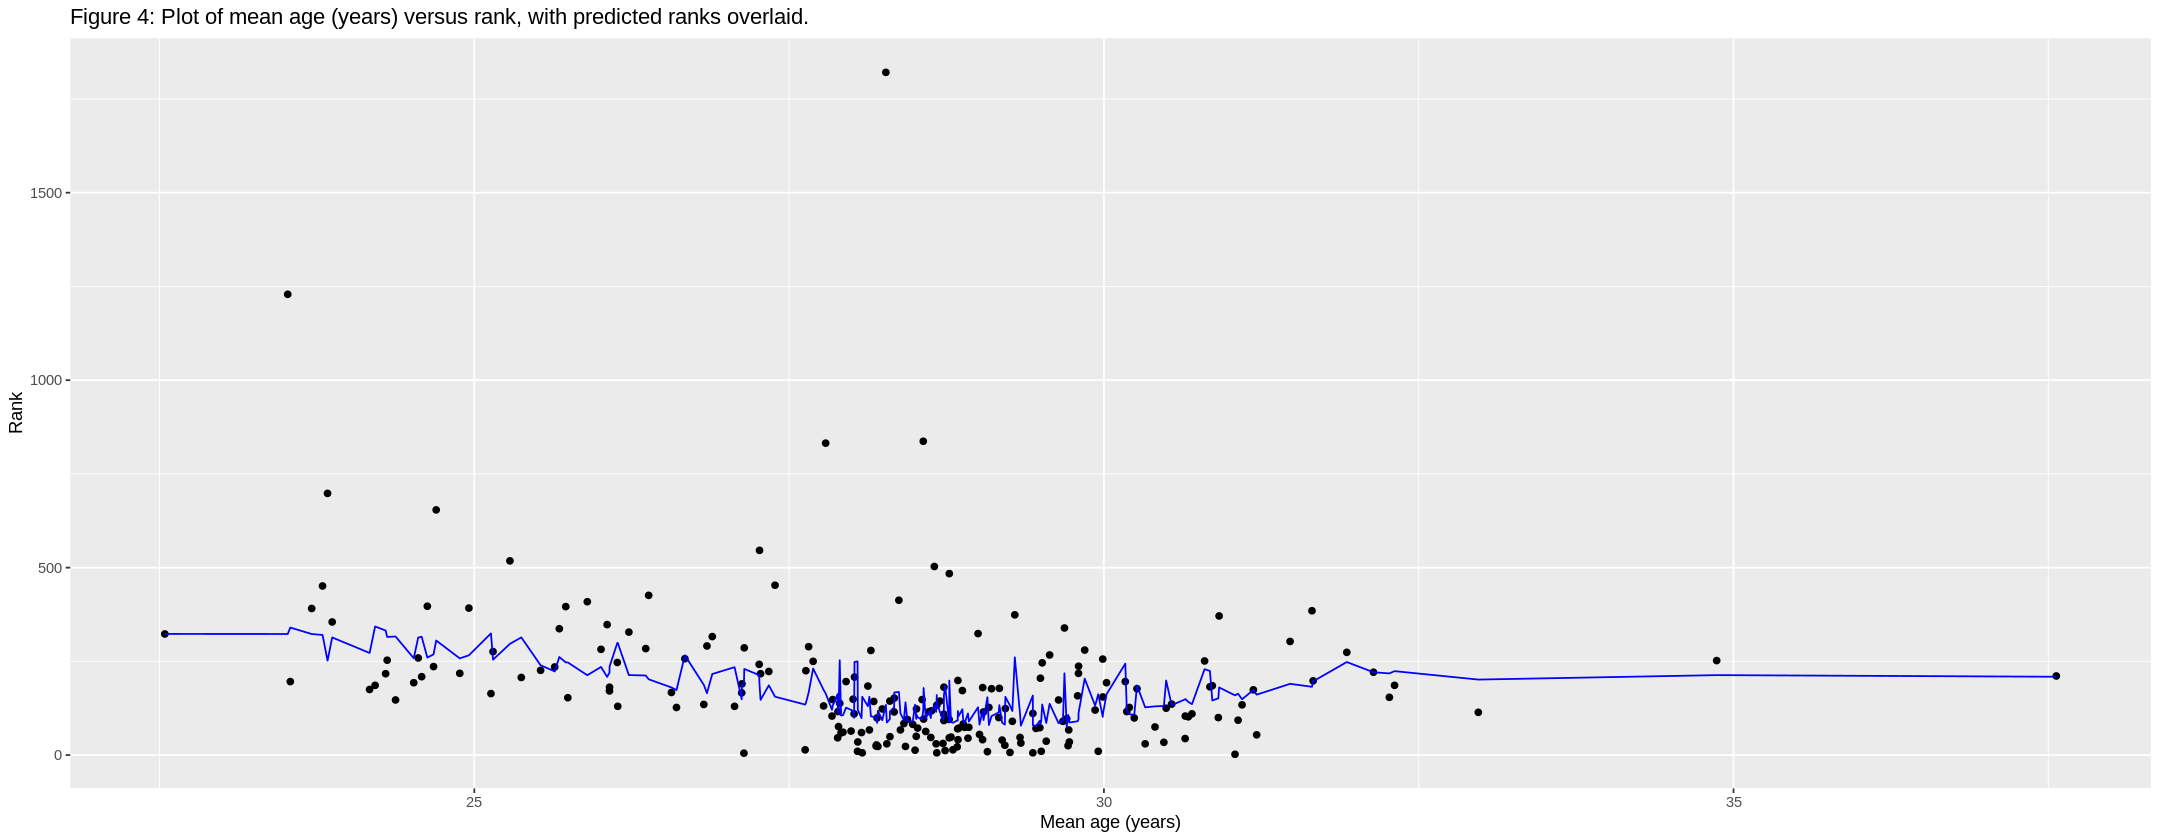

In [12]:
ht_rank_accuracy <- tennis_accuracy |>
    ggplot(aes(y = rank, x = mean_ht)) +
        geom_point() +
        geom_line(colour = "blue",
                  mapping = aes(y = .pred, x = mean_ht)) +
        labs(y = "Rank", x = "Mean height (cm)") +
        ggtitle("Figure 3: Plot of mean height (cm) versus rank, with predicted ranks overlaid.")
ht_rank_accuracy

ht_age_accuracy <- tennis_accuracy |>
    ggplot(aes(y = rank, x = mean_age)) +
        geom_point() +
        geom_line(colour = "blue",
                  mapping = aes(y = .pred, x = mean_age)) +
        labs(y = "Rank", x = "Mean age (years)") +
        ggtitle("Figure 4: Plot of mean age (years) versus rank, with predicted ranks overlaid.")
ht_age_accuracy

We made two plots to visualise our K-nearest neighbour algorithm for both predictors.  

In [14]:
new_player <- tibble(mean_ht = 165, mean_age = 25)
prediction <- tennis_fit|>
    predict(new_player)
print("Table 6: The predicted rank given by our predictive model to a player of height 165cm and age 25.")
prediction

[1] "Table 6: The predicted rank given by our predictive model to a player of height 165cm and age 25."


.pred
<dbl>
332.254


We added a new player with age: 25 and height: 165cm and predicted that their rank would be 332
